In [1]:
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [3]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# テストデータをdatasetsからダウンロード
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
len(test_data)

10000

In [5]:
batch_size = 64

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [6]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.300858  [    0/60000]
loss: 2.295453  [ 6400/60000]
loss: 2.285138  [12800/60000]
loss: 2.283310  [19200/60000]
loss: 2.278956  [25600/60000]
loss: 2.245662  [32000/60000]
loss: 2.256824  [38400/60000]
loss: 2.232105  [44800/60000]
loss: 2.239126  [51200/60000]
loss: 2.195680  [57600/60000]
Test Error: 
 Accuracy: 39.1%, Avg loss: 0.034838 

Epoch 2
-------------------------------
loss: 2.225896  [    0/60000]
loss: 2.233206  [ 6400/60000]
loss: 2.187004  [12800/60000]
loss: 2.193766  [19200/60000]
loss: 2.188744  [25600/60000]
loss: 2.111134  [32000/60000]
loss: 2.144741  [38400/60000]
loss: 2.090262  [44800/60000]
loss: 2.118416  [51200/60000]
loss: 2.021732  [57600/60000]
Test Error: 
 Accuracy: 40.6%, Avg loss: 0.032658 

Epoch 3
-------------------------------
loss: 2.095242  [    0/60000]
loss: 2.118020  [ 6400/60000]
loss: 2.013456  [12800/60000]
loss: 2.040857  [19200/60000]
loss: 2.030102  [25600/60000]
loss: 1.887101  [32000/600

In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [12]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


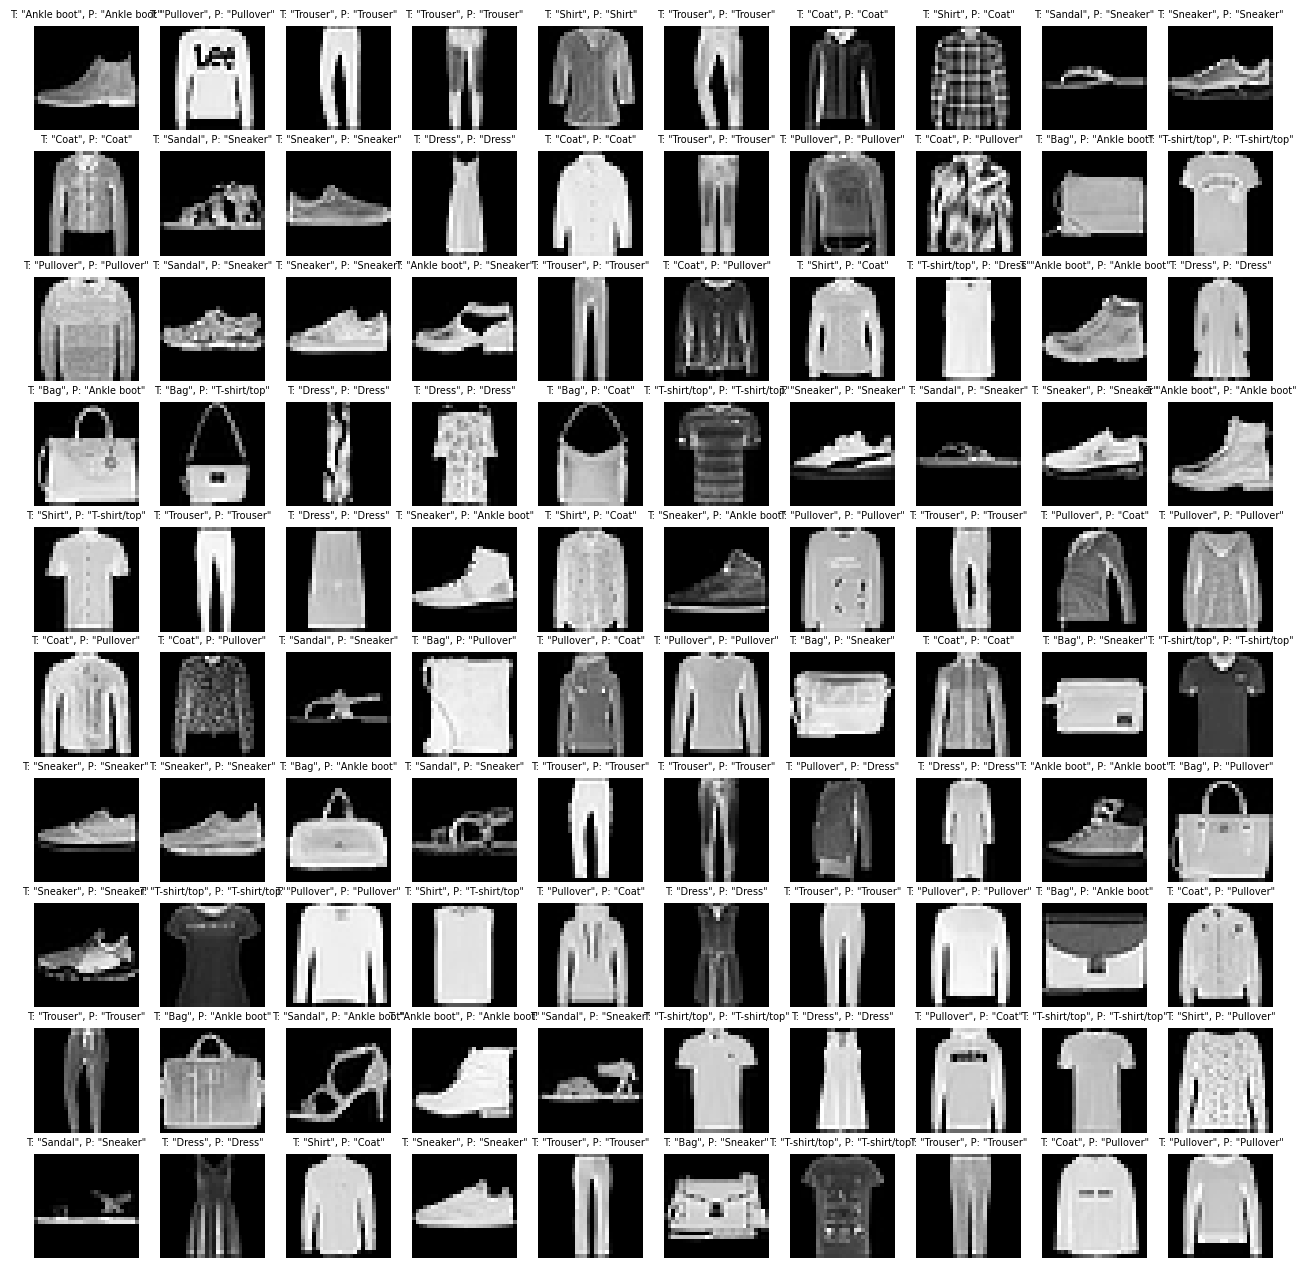

In [14]:

figure = plt.figure(figsize=(16, 16))
cols, rows = 10, 10

for i in range(rows):
    for j in range(cols):
        x, y = test_data[i*cols+j][0], test_data[i*cols+j][1]
        
        with torch.no_grad():
            model.eval()

            pred = model(x)

            predicted, actual = classes[pred[0].argmax(0)], classes[y]
            
            figure.add_subplot(rows, cols, i*cols+j+1)
            plt.title(f'T: "{actual}", P: "{predicted}"', fontsize=7)
            plt.axis("off")
            plt.imshow(x.squeeze(), cmap="gray")

In [15]:
type(test_data)

torchvision.datasets.mnist.FashionMNIST

In [16]:
test(test_dataloader, model)

Test Error: 
 Accuracy: 55.8%, Avg loss: 0.022648 

